In [12]:
%%capture


pip install anvil-uplink

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
# the api key identifer connecting google colab to the web application

import anvil.server

anvil.server.connect("server_XDBLRWVSJZCVINH6S6E5YGKR-DYNAAZRSLOQAEAB4")

In [16]:
#importing the libraries
import torch
import sys
import os
from PIL import Image
from tqdm.notebook import tqdm

In [17]:
%%capture

# matching with torch version and platform name to install pytorch
# this is a standard code for installing pytorch 3D

if torch.__version__.startswith("2.2.") and sys.platform.startswith("linux"):
        pytVersionStr=torch.__version__.split("+")[0].replace(".", "")
        versionStr="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pytVersionStr}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{versionStr}/download.html

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
from pytorch3d.io import save_obj,load_objs_as_meshes
from pytorch3d.loss import chamfer_distance as chamferD
from pytorch3d.loss import mesh_edge_loss as meshEL
from pytorch3d.loss import mesh_laplacian_smoothing as meshLS
from pytorch3d.loss import mesh_normal_consistency as meshNC
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.renderer import look_at_view_transform as LAV_transform
from pytorch3d.renderer import FoVPerspectiveCameras as FPC
from pytorch3d.renderer import PointLights as PLights
from pytorch3d.renderer import DirectionalLights as DLights
from pytorch3d.renderer import Materials
from pytorch3d.renderer import RasterizationSettings as RastSet
from pytorch3d.renderer import MeshRenderer as MRend
from pytorch3d.renderer import MeshRasterizer as MRaster
# from pytorch3d.renderer import SoftPhongShader
from pytorch3d.renderer import SoftSilhouetteShader as SSShader
from pytorch3d.renderer import SoftPhongShader as SPShader
from pytorch3d.renderer import TexturesVertex



In [5]:
dev = torch.device("cuda:0")
torch.cuda.set_device(dev)

In [23]:
folder_path = './color'

os.makedirs(folder_path, exist_ok=True)

number_of_images = 8

# the follwing varibales are useful when generating images from the obj file. helpful during the optimization loop

elevation = torch.linspace(0,360, number_of_images)
azimuth = torch.linspace(-180,180, number_of_images)


pointlights = PLights(device=dev, location=[[0.0, 0.0, -3/10]])


Rotation, Translation = LAV_transform(dist=27/10, elev=elevation, azim=azimuth)


cam = FPC(device=dev, R=Rotation[None, 1, ...],
                                  T=Translation[None, 1, ...])


targetcameras = [FPC(device=dev, R=Rotation[None, j, ...],
                                           T=Translation[None, j, ...]) for j in range(number_of_images)]

sigmavariable = 0.0001
raster_silhouette = RastSet(
    image_size=128,
    faces_per_pixel=50,
    blur_radius=np.log(1. / 0.0001 - 1.)*sigmavariable,
)

# to render the silouttes during the optimization loop
silhouette_renderer = MRend(
    rasterizer=MRaster(
        cameras=cam,
        raster_settings=raster_silhouette
    ),
    shader=SSShader()
)

In [19]:
%%capture

!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

In [8]:
# mounting the google drive so that the obj file can be uploaded to the the drive.
# don't worry the flder in which the object goes in to is made accessible to whomever having the link
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [9]:
# anvil.media help with transferring images between the google collab and the anvil web application platform
import anvil.media

# when the images are uploaded in the webapp save function is called
@anvil.server.callable
def save(image,name):
  from PIL import Image

  with anvil.media.TempFile(image) as image:
    print(name)
    img = Image.open(image)
    img.save("./color/"+name)

  return "done"

In [34]:
# this part is ran when submit button in the wen application is ran
@anvil.server.callable
def Generator():
  # defining the folder path
  fold_path = "./color/"
  # Image function to process the input images
  from PIL import Image
  images = []
  # getting the images in the color folder
  for filee in sorted(os.listdir(fold_path)):
      if filee.endswith(('.jpg', '.jpeg', '.png', '.gif')):
          img = Image.open(fold_path+filee)
          images.append(img)
  from torchvision import transforms as tfm
  # transform function is used to generate torch tensors for the input images
  # if the images sizes are not 128 x 128, then we can use transforms.Resize
  transform = tfm.Compose([
      # transforms.Resize((128, 128)),  # Resize image
      tfm.ToTensor(),           # Convert image to tensor
  ])


  target_rgb = []
  for img in images:
    tensor_image = transform(img)
    tensor_image_cuda = tensor_image.to('cuda')
    # permute will rearrenage the layers in the images need to compute
    tensor_image_cuda = tensor_image_cuda.permute(1,2,0)
    target_rgb.append(tensor_image_cuda)
  # The torch tensor individual images are stacked together to form collection of torch tensors- needed for visualization purposes
  combined_tensor_color = torch.stack(target_rgb)
  # image gride will display 8 images
  image_grid(combined_tensor_color.cpu().numpy(), rows=2, cols=4, rgb=True)
  plt.show()
  silimages = []

  # manual processs of generating siloutte images from input images


  for img in images:
      image = img

      # inverting the images to form a distinction between target image and the background
      inverted_img = Image.eval(image, lambda x: 255 - x)

      #forming the grayscale image
      grayscale_image = inverted_img.convert("L")

      #defining a new image for the grayscale image
      bw_image = Image.new("L", grayscale_image.size, 0)

      # converting the grayscale image to black and white
      for x in range(grayscale_image.width):
          for y in range(grayscale_image.height):
              if grayscale_image.getpixel((x, y)) > 10:
                  bw_image.putpixel((x, y), 255)

      silimages.append(bw_image)
  target_silhouette = []

  # transform function is used to generate torch tensors for the siloutte images
  for img in silimages:
    tensor_image = transform(img)
    tensor_image_cuda = tensor_image.to('cuda')
    tensor_image_cuda = tensor_image_cuda[0]
    target_silhouette.append(tensor_image_cuda)
  # stacking the siloutte tensors
  combined_tensor_sil = torch.stack(target_silhouette)
  expanded_combined_tensor_sil = combined_tensor_sil.unsqueeze(3)
  # image gride will display 8 images. The follwoing code make it feasible for the image gride to display images
  expanded_combined_tensor_sil = expanded_combined_tensor_sil.repeat(1,1,1,4)
  image_grid(expanded_combined_tensor_sil.cpu().numpy(), rows=2, cols=4, rgb=False)
  plt.show()
  # following code help to visualize siloutte images of the 3D object during each iteration
  def viz_outputs(mesh_predicted, renderer=silhouette_renderer,
                         trgt=target_rgb[1], tit_val='',
                         sil=False):
    inds = 3 if sil else range(3)
    with torch.no_grad():
        images_pred = renderer(mesh_predicted)
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1)
    plt.imshow(images_pred[0, ..., inds].cpu().detach().numpy())

    plt.subplot(1, 2, 2)
    plt.imshow(trgt.cpu().detach().numpy())
    plt.title(tit_val)
    plt.axis("off")

  # help to display the 4 type of losses

  def display_loss_values(values_of_loss):
      fig = plt.figure(figsize=(15, 6))
      ax = fig.gca()
      for val_k, val_l in values_of_loss.items():
          ax.plot(val_l['values'], label=val_k + " loss")
      ax.legend(fontsize="16")
      ax.set_xlabel("loops", fontsize="10")
      ax.set_ylabel("value_of_loss", fontsize="10")
      ax.set_title("value_of_Loss vs loops", fontsize="10")

  # define the base sphere will be moulded to get the target object
  source_mesh_object = ico_sphere(4, dev)
  num_views_per_iteration = 3
  # defining the number of iteration
  Niter_count = 2000
  plot_period = 250

  %matplotlib inline

  # initializing the losses
  different_losses = {"loss_silhouette": {"weight": 1.0, "values": []},
            "loss_edge": {"weight": 1.0, "values": []},
            "loss_normal": {"weight": 0.01, "values": []},
            "loss_laplacian": {"weight": 1.0, "values": []},
          }

  # function to update the losses. The losses will be updated during each iteration
  def updating_the_different_losses(data_meshh, loss_inst):
      loss_inst["loss_edge"] = meshEL(data_meshh)

      loss_inst["loss_normal"] = meshNC(data_meshh)

      loss_inst["loss_laplacian"] = meshLS(data_meshh, method="uniform")


  # defining the vertices of the base sphere
  Vertices_Shape = source_mesh_object.verts_packed().shape


  deformed_vertices = torch.full(Vertices_Shape, 0.0, device=dev, requires_grad=True)

  opttim_object = torch.optim.SGD([deformed_vertices], lr=1.0, momentum=0.9)
  optimization_loop = tqdm(range(Niter_count))

  # beginning the optimization loop
  for i in optimization_loop:
      opttim_object.zero_grad()

      new_source_mesh_object = source_mesh_object.offset_verts(deformed_vertices)

      # updating the loss
      loss = {k: torch.tensor(0.0, device=dev) for k in different_losses}
      updating_the_different_losses(new_source_mesh_object, loss)




      for j in np.random.permutation(number_of_images).tolist()[:num_views_per_iteration]:

          # getting the siloutte image of the moudling sphere during the ieration
          images_predicted = silhouette_renderer(new_source_mesh_object, cameras=targetcameras[j], lights=pointlights)
          predicted_silhouette = images_predicted[..., 3]

          # finding the differenece between the predicted and target siloutte
          # which the siloutte loss
          loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
          loss["loss_silhouette"] += loss_silhouette / num_views_per_iteration




      # updating the weight and value parameters of the losses
      summation_of_losses = torch.tensor(0.0, device=dev)
      for k, l in loss.items():
          summation_of_losses += l * different_losses[k]["weight"]
          different_losses[k]["values"].append(float(l.detach().cpu()))


      optimization_loop.set_description("total_loss = %.6f" % summation_of_losses)

      if i % plot_period == 0:
          viz_outputs(new_source_mesh_object, tit_val="iter: %d" % i, sil=True,
                              trgt=target_silhouette[1])


      # backward propogation to update the sphere based on the losses
      summation_of_losses.backward()
      opttim_object.step()
  viz_outputs(new_source_mesh_object, sil=True,
                       trgt=target_silhouette[1])

  # finally display the losses
  display_loss_values(different_losses)
  Final_Vertices, Final_surfaces = new_source_mesh_object.get_mesh_verts_faces(0)

  # saving the 3D object in target folder
  ThreeDobj = os.path.join('./', 'output.obj')
  save_obj(ThreeDobj, Final_Vertices, Final_surfaces)
  from google.colab import files

  # shutil library is used to save the obj file on the google drive
  import shutil
  colab_file_path = './output.obj'
  drive_folder_path = '/content/drive/My Drive/objfile/'

  # Copy the file from Colab to Drive
  shutil.copy(colab_file_path, drive_folder_path)
  shutil.rmtree(fold_path)
  folder_path = './color'

  os.makedirs(folder_path, exist_ok=True)

  # return the path of obj file to the web application
  return "https://drive.google.com/drive/u/0/folders/1hHRwoLQRmiWm3BKhnhXOJXfKLNixuFdS"


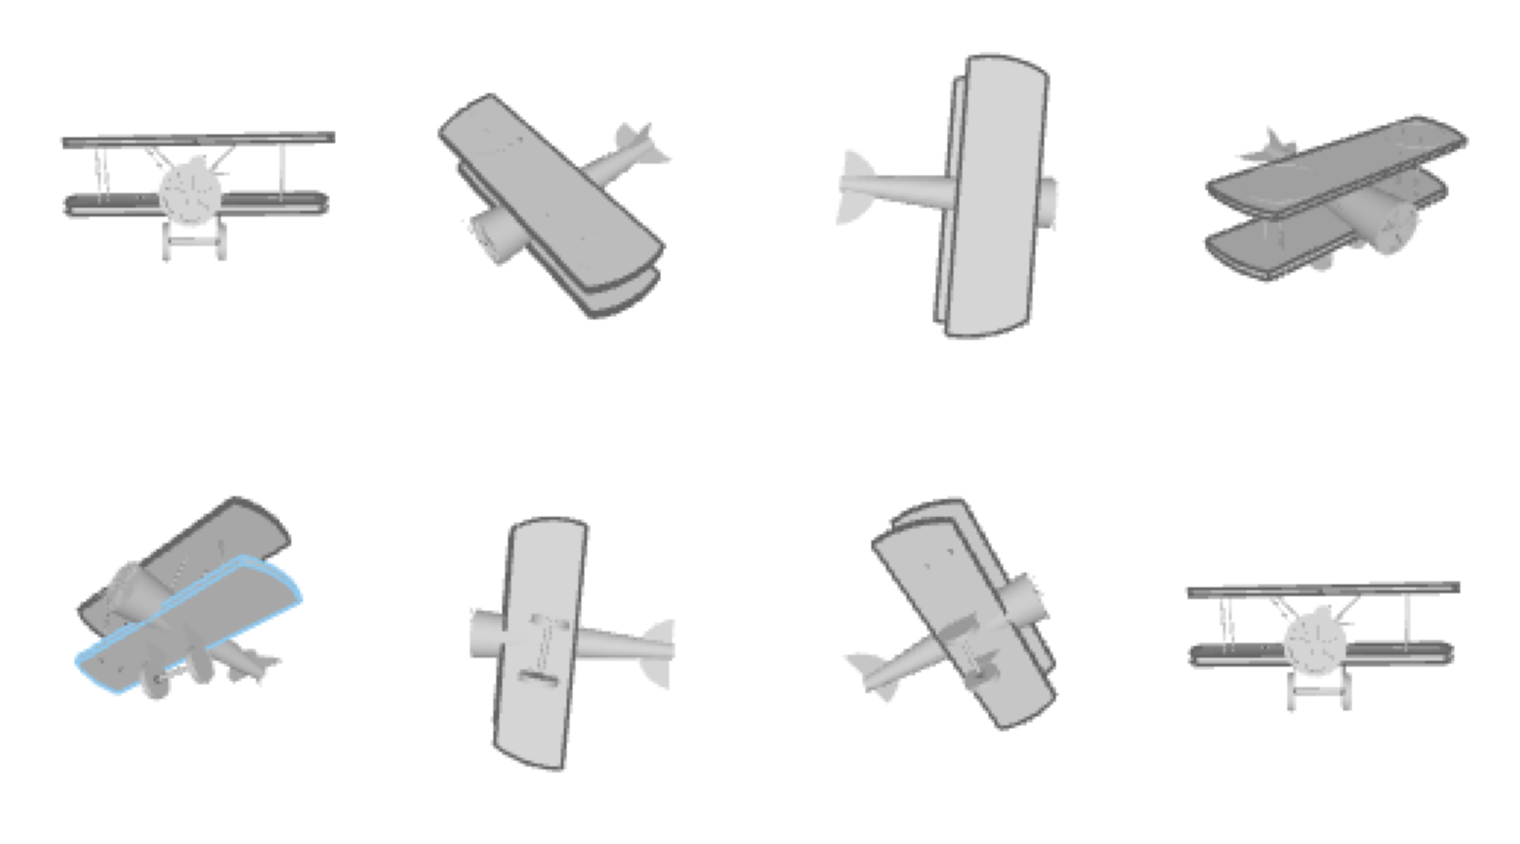

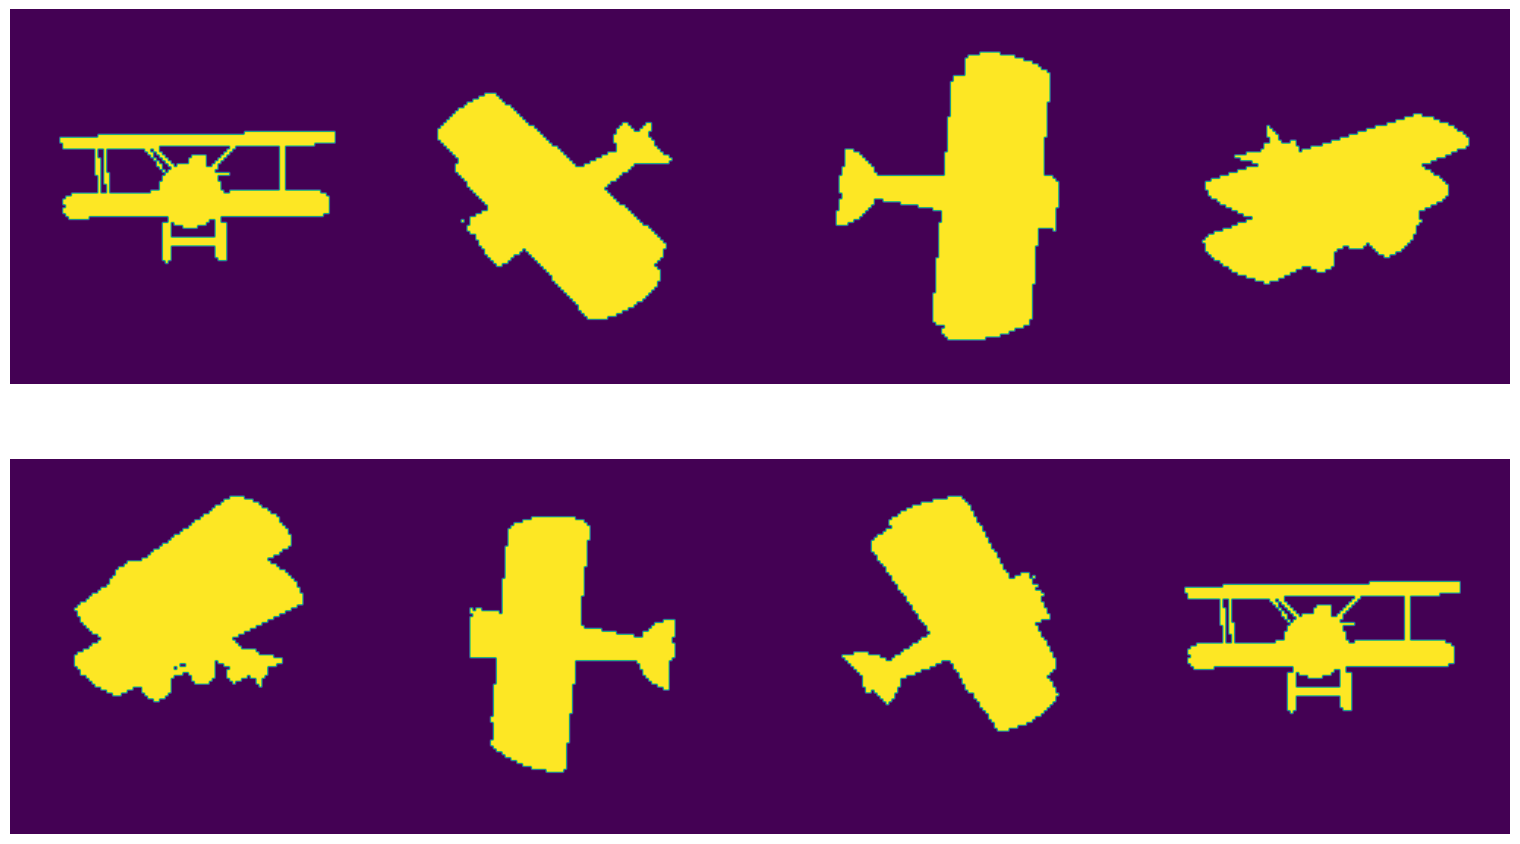

  0%|          | 0/2000 [00:00<?, ?it/s]

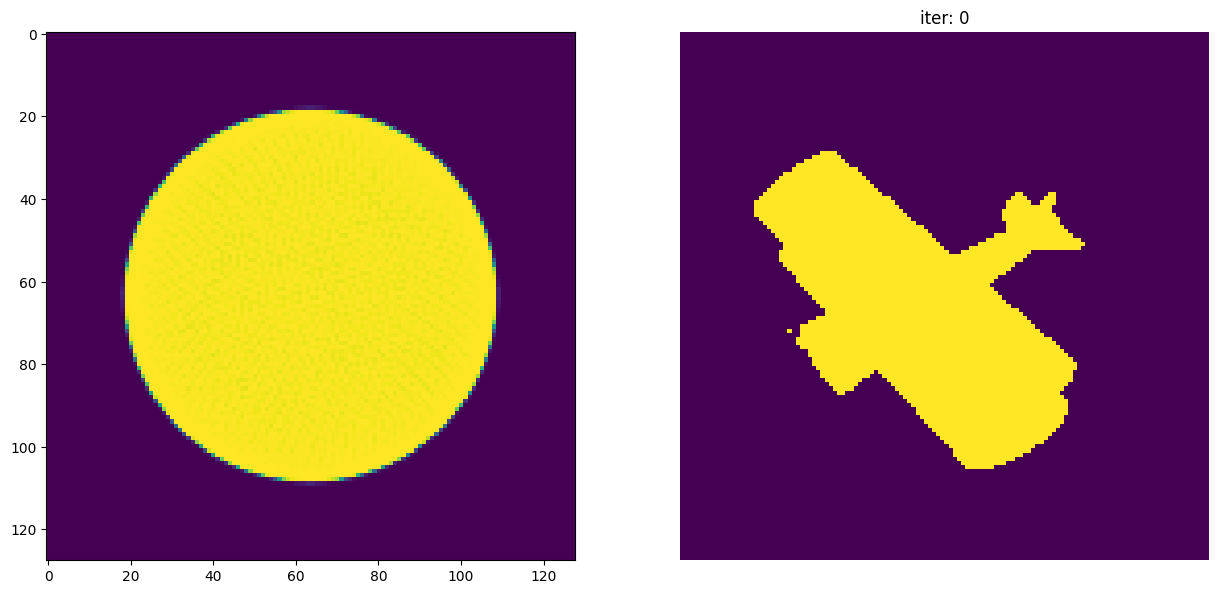

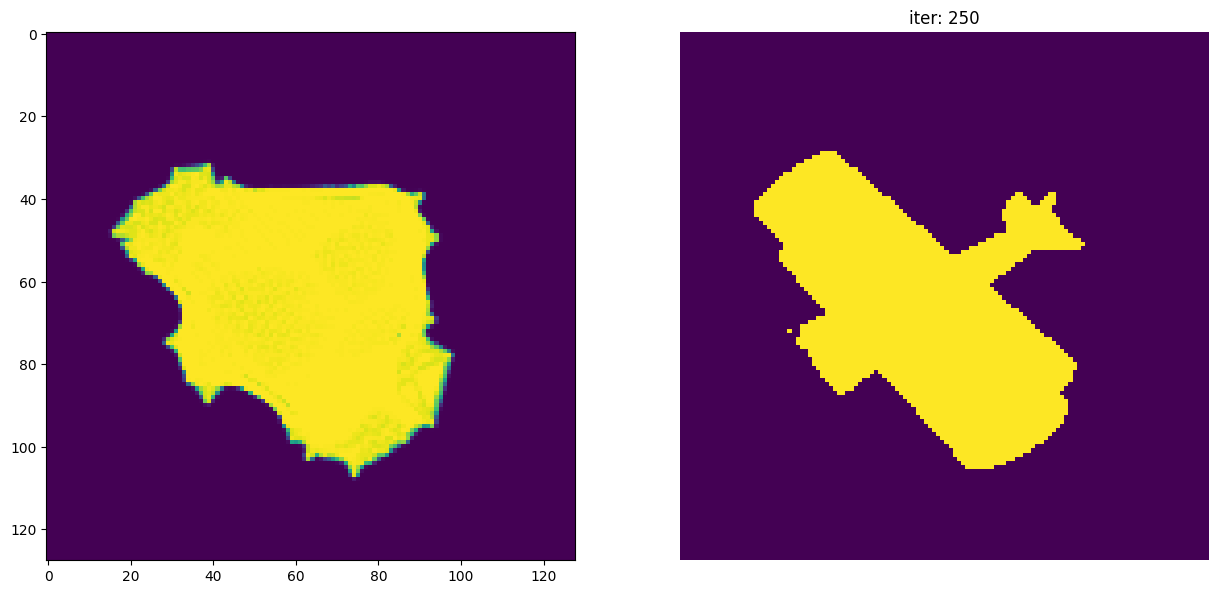

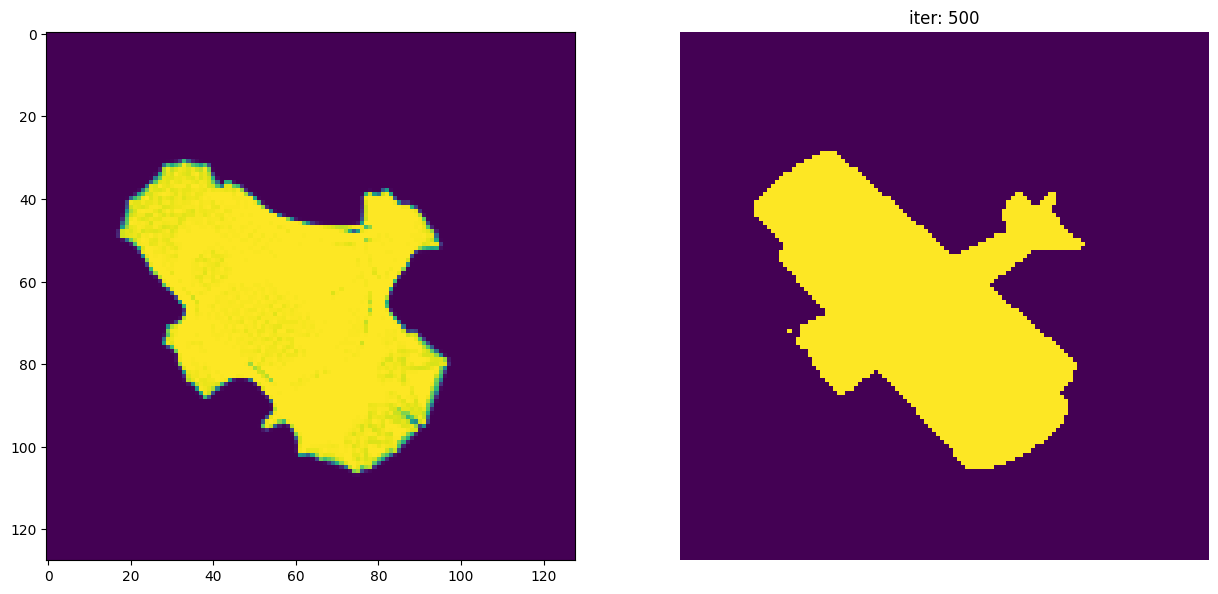

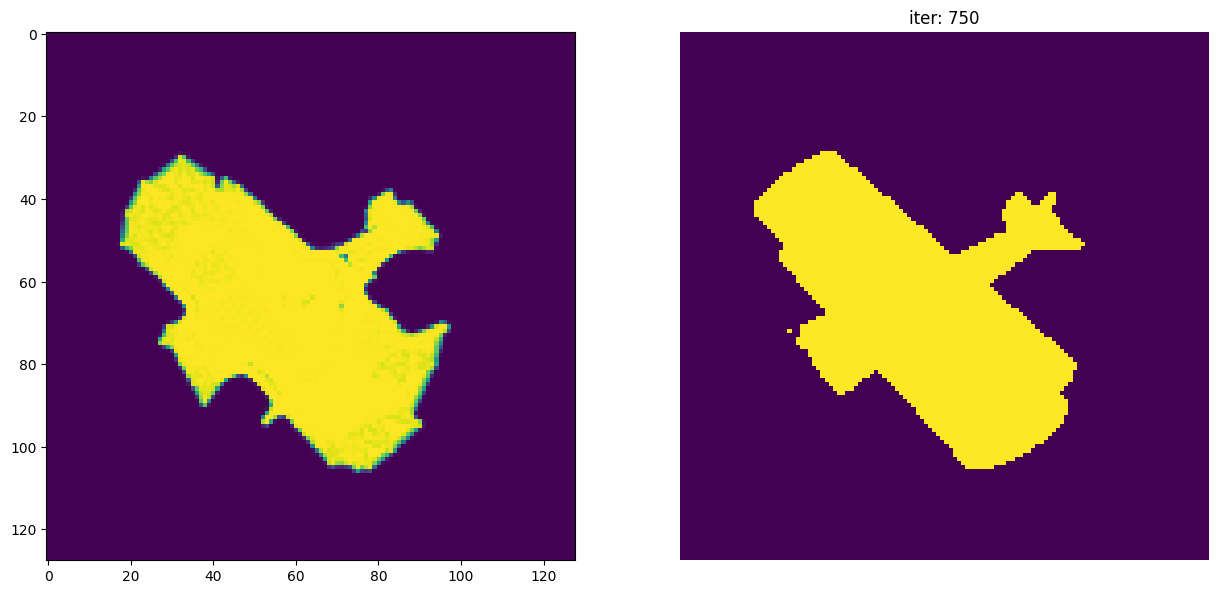

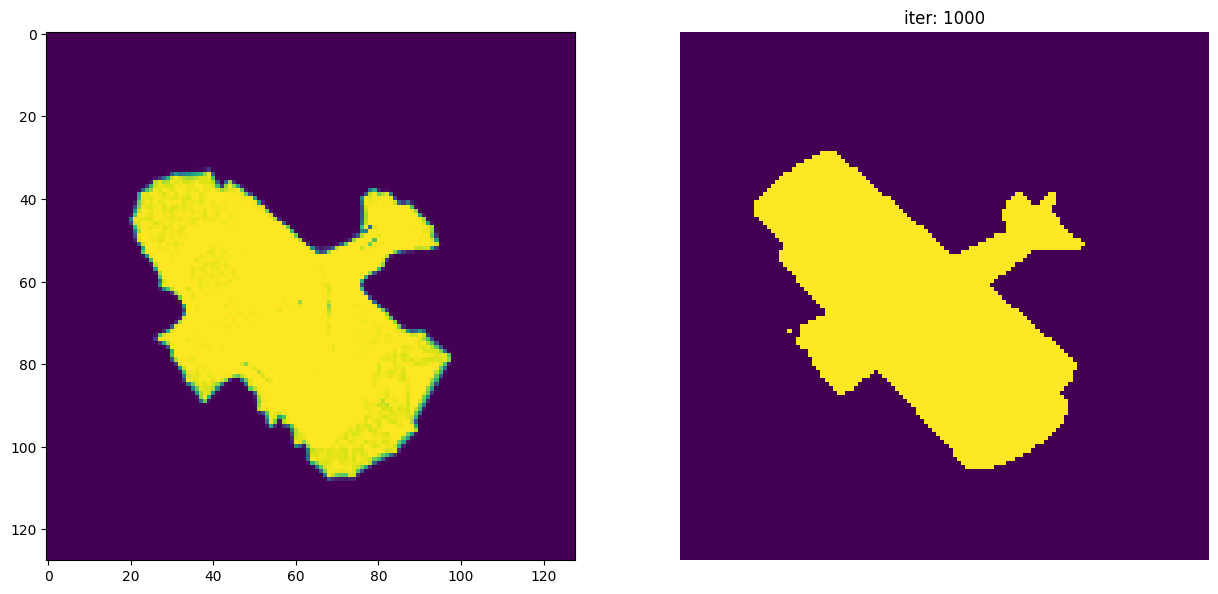

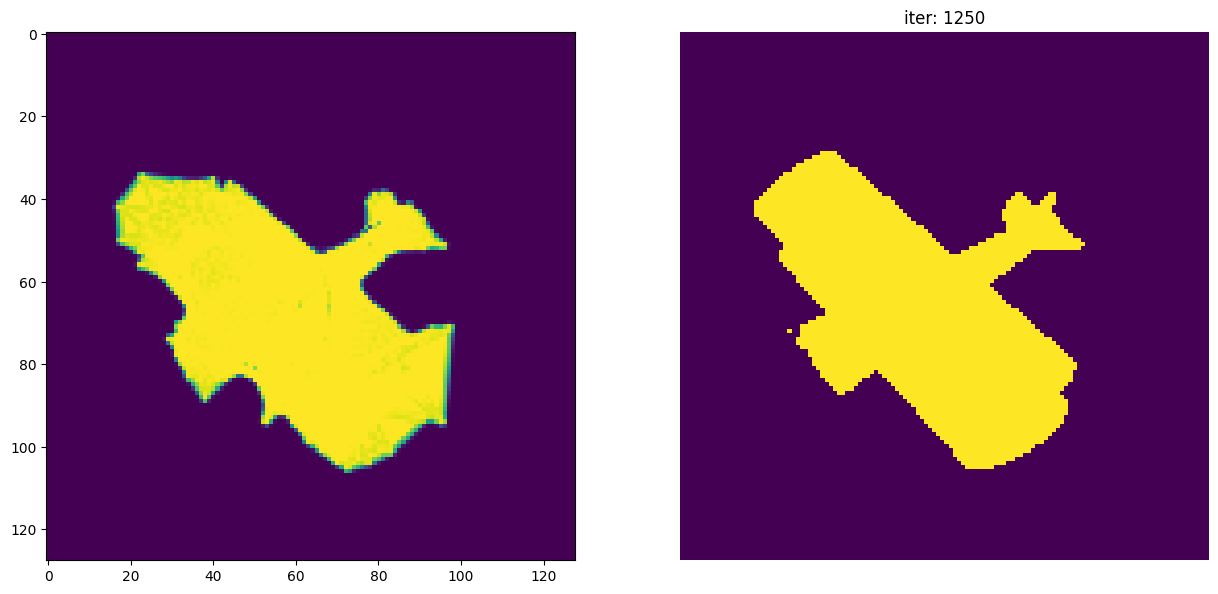

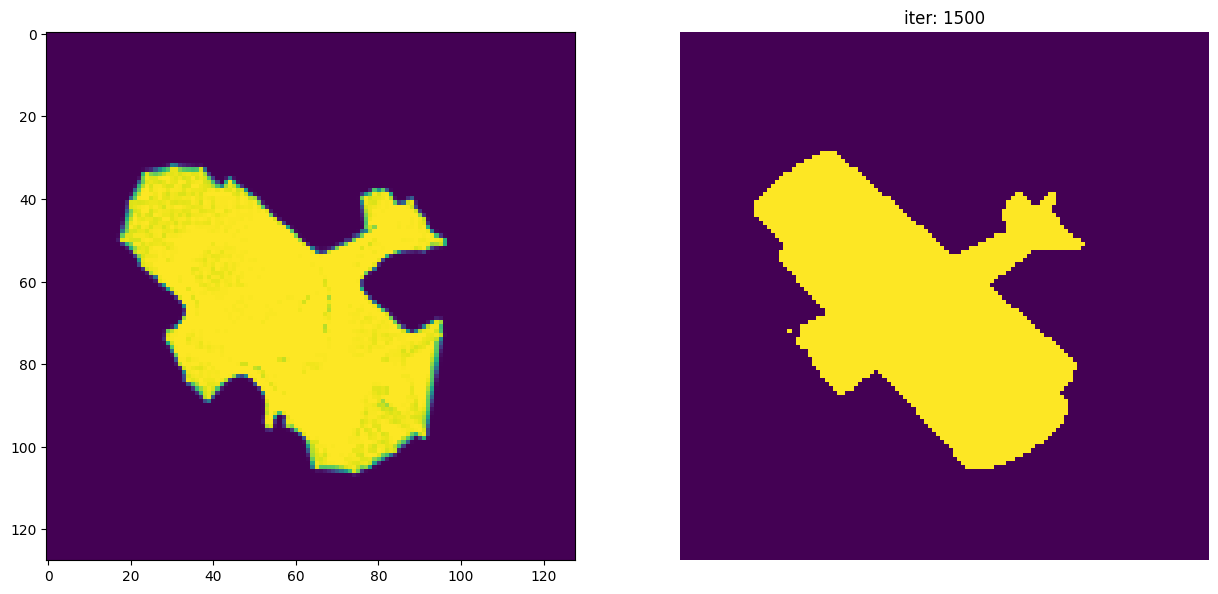

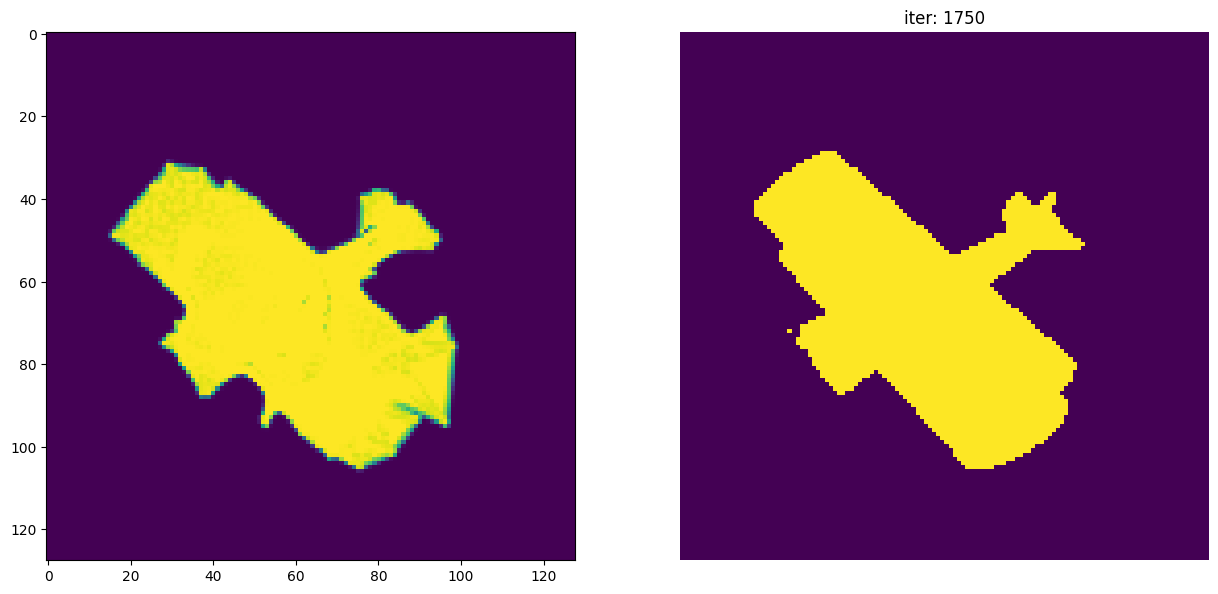

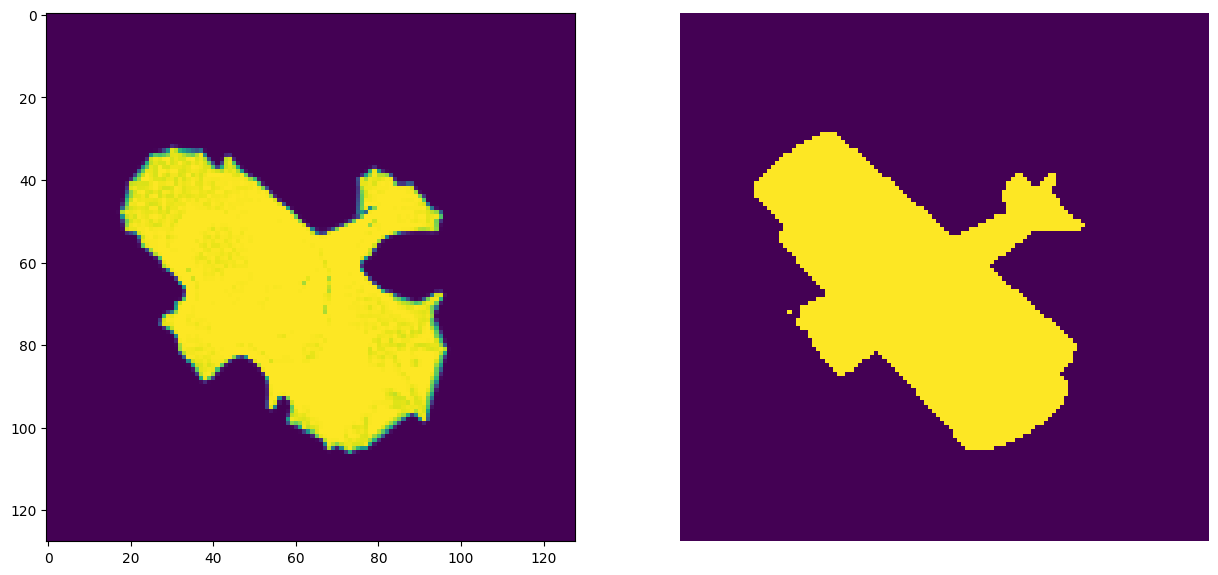

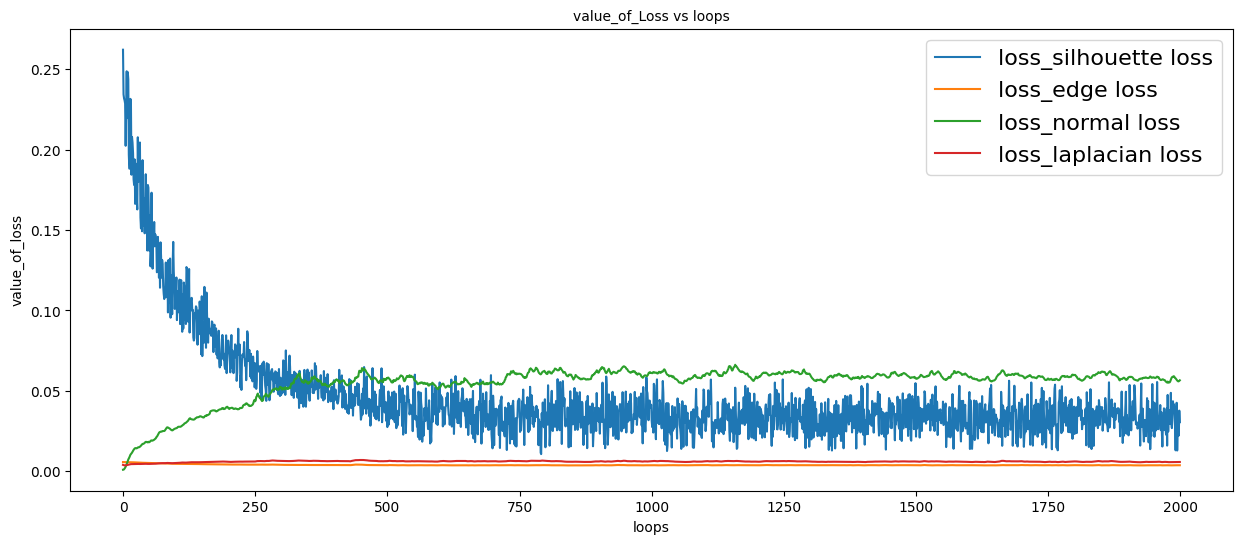

In [36]:
out = Generator()

image06.png
image07.png
image08.png


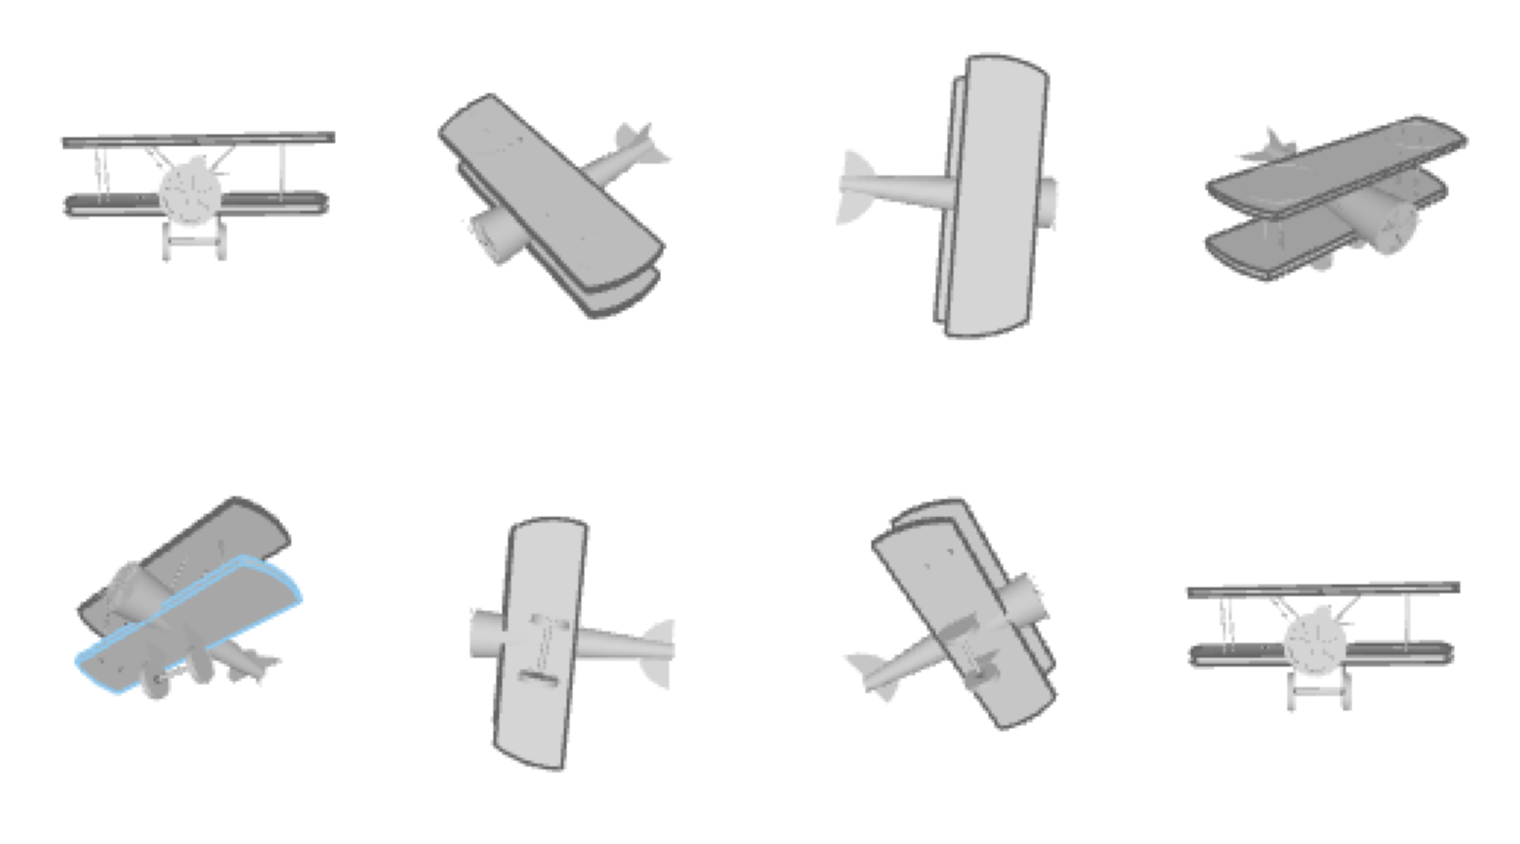

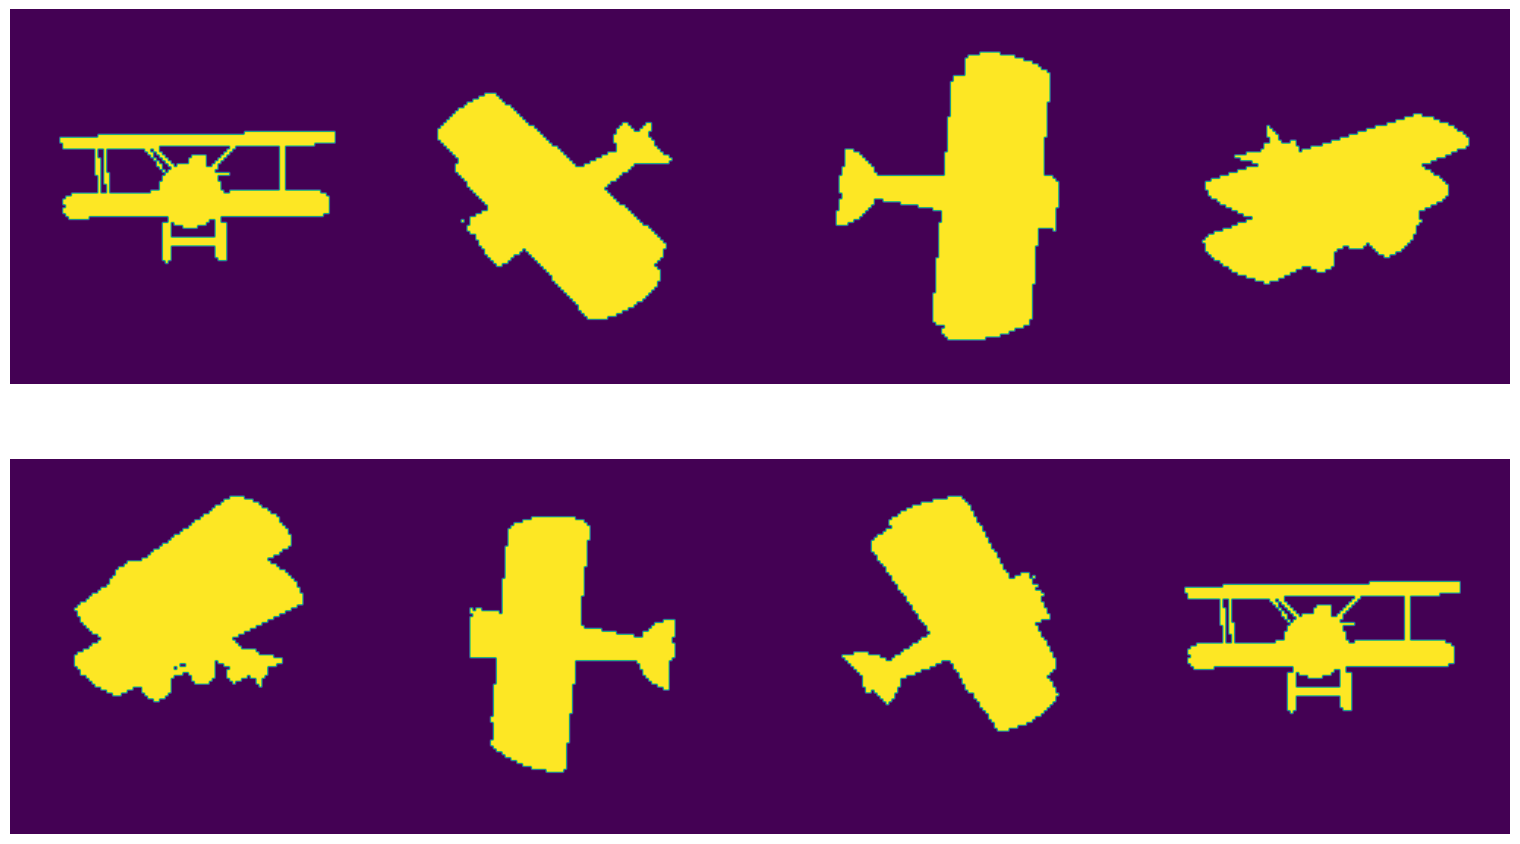

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
# the google VM is ran until it get disconnected
anvil.server.wait_forever()